# Setup Variables

MNIST, FashionMNIST, GTSRB, Cifar10

In [196]:
DATASET = 'MNIST'
POSTFIX = 'SGD-32-60'
FILENAME_POSTFIX = f'{DATASET}_{POSTFIX}'
SEED = 42
CUDA = 0
LHL = int(POSTFIX.split('-')[-1])
GPU_NAME = f'cuda:{CUDA}'

In [197]:
TEST_DATASET = 'FashionMNIST'
TEST_POSTFIX = 'AdamW-64-60'
TEST_FILENAME_POSTFIX = f'{TEST_DATASET}_{TEST_POSTFIX}'

In [198]:
import os
from pathlib import Path

base = Path().cwd()

if base.name != 'runtime-monitoring':
    os.chdir('../')
    base = Path().cwd()

base

PosixPath('/home/ah19/runtime-monitoring')

In [199]:
# disable warnings
import warnings
warnings.filterwarnings('ignore')

# Libraries

In [200]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from fastprogress import progress_bar

from utilities.utils import *
from utilities.pathManager import fetchPaths
from utilities.MonitorUnifiedBDD import MonitorBDD

# Paths

In [201]:
paths = fetchPaths(base, DATASET, POSTFIX, False)

path_data = paths['data']
path_lhl = paths['lhl']
path_lhl_raw = paths['lhl_raw']
path_lhl_pca = paths['lhl_scaler_pca']


# load config file
configs = load_json(paths['configuration'])
config = configs['configuration']

# model config
model_setup = configs['model_setup']
model_config = configs['model_config']

# saved model
path_model = next(paths['saved_models'].glob('*.pth.tar'))

path_model

PosixPath('/home/ah19/runtime-monitoring/experiments/MNIST/saved-models/MNIST_SGD-32-60/MNIST_SGD-32-60-acc-0.983-loss-0.063.pth.tar')

In [202]:
test_paths = fetchPaths(base, TEST_DATASET, TEST_POSTFIX, False)

test_path_data = test_paths['data']
test_path_lhl = test_paths['lhl']
test_path_lhl_raw = test_paths['lhl_raw']
test_path_lhl_pca = test_paths['lhl_scaler_pca']

# Get LHL Data for the Test Dataset

In [203]:
import torch
import torchvision
import torch.nn as nn
import torch.backends.cudnn as cudnn

In [204]:
from models.mnist_model import MNIST_Model
from models.fashionmnist_model import FashionMNIST_CNN
from models.gtsrb_model import GTSRB_CNN
from models.cifar10_dla import Cifar10_DLA
from models.cifar10_model import Cifar10_CNN

from models.transformers import transformers

models = {
    'mnist': MNIST_Model,
    'fashionmnist': FashionMNIST_CNN,
    'gtsrb': GTSRB_CNN,
#     'cifar10': Cifar10_DLA,
    'cifar10': Cifar10_CNN
}

model_ = models[DATASET.lower()]
transformer = transformers[DATASET.lower()]

In [205]:
device = get_device(GPU_NAME)
torch.cuda.get_device_name(device)

'NVIDIA A100 80GB PCIe'

In [206]:
feature_names_test = get_labels(TEST_DATASET)

# train_data = get_dataset(TEST_DATASET, test_path_data, train=True, transform=transformer['train'])
test_data = get_dataset(TEST_DATASET, test_path_data, train=False)

In [207]:
_, test_sample = train_test_split(
    torch.range(0, len(test_data.targets)-1, dtype=torch.int32),
    test_size=1000, shuffle=True, stratify=test_data.targets
)

testloader = get_dataLoader(test_data, model_config['batch_size'], False)

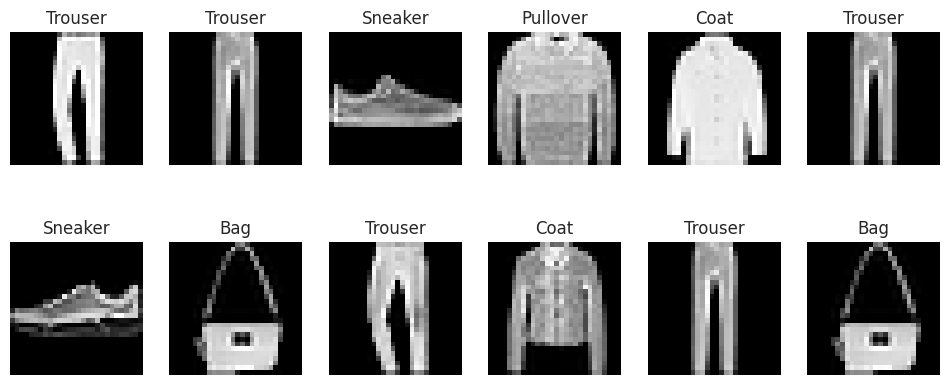

In [208]:
show_images_loader(testloader, feature_names=feature_names_test)

In [209]:
# torch 2.0 compile and parallel data training
model_setup['last_hidden_neurons'] = LHL
model = model_(**model_setup).to(device)
model = torch.compile(model)

# load model weights
model.load_state_dict(torch.load(path_model)['model'])

# eavluation mode
model.eval()

''

''

In [210]:
mean_, std_ = transformer['test'].transforms[1].mean, transformer['test'].transforms[1].std
mean_, std_

(0.1307, 0.3015)

In [211]:
x = torch.stack([test_data[i][0] for i in test_sample]) - mean_ / std_

In [212]:
x.shape

torch.Size([1000, 1, 28, 28])

In [213]:
logits, _ = model.output_last_layer(x.to(device))
logits = logits.cpu().numpy()
logits = pd.DataFrame(logits, columns=[f'x{i}' for i in range(logits.shape[1])])
logits.shape

(1000, 60)

In [214]:
# res = torch.zeros((len(testloader), model_config['batch_size'], LHL))

In [215]:
# for i, (x, _) in enumerate(trainloader):
#     x = x.to(device)
#     logits, _ = model.output_last_layer(x)
#     res[i] = logits

In [216]:
# (res.reshape([len(train_data), LHL])[:model_config['batch_size']] == res[0]).all()

In [217]:
# inference_df = pd.DataFrame(res.reshape([len(train_data), LHL]), columns=[f'x_{i}' for i in range(LHL)])

In [218]:
# num_samples = 20

# viz_sample = inference_df.sample(num_samples)
# x = np.repeat(np.arange(LHL, dtype=np.int8), num_samples) + 1

# Seed

In [219]:
np.random.seed(SEED)

# Import Data

In [220]:
FLAVOR = 'raw'

if FLAVOR == 'raw':
    path_lhl = path_lhl_raw
else: path_lhl = path_lhl_pca

# import Data
df_train = pd.read_csv(path_lhl / f"{FILENAME_POSTFIX}_{FLAVOR}_train.csv")

# select only true classified
df_true = df_train[df_train["true"] == True].copy()
df_true = df_true.drop("true", axis=1).reset_index(drop=True)

df_test = pd.read_csv(path_lhl / f"{FILENAME_POSTFIX}_{FLAVOR}_test.csv")

print(f"Train accuracy: {(df_train['true'].sum() / df_train.shape[0] * 100).round(2)}%")
print(f"Test accuracy: {(df_test['true'].sum() / df_test.shape[0] * 100).round(2)}%")

Train accuracy: 98.44%
Test accuracy: 98.26%


In [221]:
# each set of data has its own threshold
thld_p = 0.5
eta = 0
neurons = []

# calculate threshold
thld = np.quantile( df_true.drop('y', axis=1), thld_p, axis=0)

<Axes: ylabel='x0'>

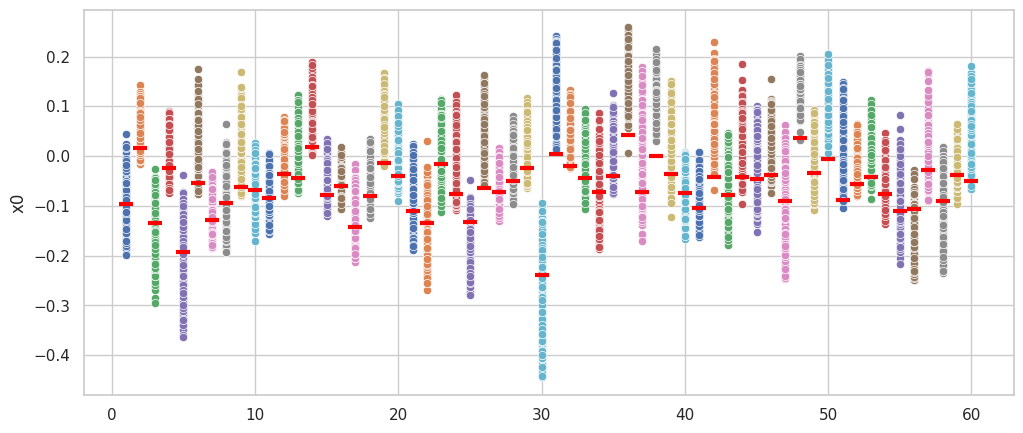

In [222]:
for i, c in enumerate(logits.columns):
    sns.scatterplot( x=i+1,  y=logits[c] )

sns.scatterplot(
    x=[*range(1, df_true.shape[1])],
    y=thld,
    marker='_', s=100, c='red', linewidth=3

)

# Build BDD

In [223]:
# BDD
patterns = MonitorBDD( df_true.shape[1]-1, thld, neurons=neurons)
df_train_copy, df_test_copy = patterns.add_dataframe( df_true, eta, eval_dfs=[df_train.copy(), df_test.copy()] )

    
# score
df_train_scores = patterns.score_dataframe_multi_eta(df_train_copy, eta)
df_test_scores = patterns.score_dataframe_multi_eta(df_test_copy, eta)

    
# add metadata
patterns.stats['thld'] = f'qth_{thld_p}'

In [224]:
patterns.stats

,thld,eta,build_time,size_mb,reorder_time,num_patterns,num_unique_patterns,num_reorder,num_neurons,start_time,end_time
1,qth_0.5,0.0,0.346,4386.628,0.0,59065.0,54337.0,0.0,60.0,2023-07-26 14:37:30,2023-07-26 14:37:51


In [225]:
df_train_scores

,y,count,false,false_misclassified,false_classified,outOfPattern,outOfPatternMisclassified,outOfPatternClassified,eta
0,0,5923.0,28.0,28.0,0.0,0.004727,1.00000,0.0,0
1,1,6742.0,56.0,56.0,0.0,0.008306,1.00000,0.0,0
2,2,5958.0,129.0,129.0,0.0,0.021652,1.00000,0.0,0
3,3,6131.0,95.0,95.0,0.0,0.015495,1.00000,0.0,0
4,4,5842.0,111.0,111.0,0.0,0.019000,1.00000,0.0,0
5,5,5421.0,77.0,77.0,0.0,0.014204,1.00000,0.0,0
6,6,5918.0,82.0,82.0,0.0,0.013856,1.00000,0.0,0
7,7,6265.0,85.0,85.0,0.0,0.013567,1.00000,0.0,0
8,8,5851.0,124.0,124.0,0.0,0.021193,1.00000,0.0,0
9,9,5949.0,138.0,138.0,0.0,0.023197,1.00000,0.0,0


In [226]:
df_test_scores

,y,count,false,false_misclassified,false_classified,outOfPattern,outOfPatternMisclassified,outOfPatternClassified,eta
0,0,979.0,923.0,5.0,918.000000,0.942799,0.005417,0.994583,0
1,1,1133.0,716.0,3.0,713.000000,0.631951,0.004190,0.995810,0
2,2,1030.0,992.0,25.0,967.000000,0.963107,0.025202,0.974798,0
3,3,1008.0,836.0,12.0,824.000000,0.829365,0.014354,0.985646,0
4,4,980.0,947.0,22.0,925.000000,0.966327,0.023231,0.976769,0
5,5,890.0,788.0,13.0,775.000000,0.885393,0.016497,0.983503,0
6,6,956.0,842.0,22.0,820.000000,0.880753,0.026128,0.973872,0
7,7,1027.0,820.0,17.0,803.000000,0.798442,0.020732,0.979268,0
8,8,973.0,954.0,18.0,936.000000,0.980473,0.018868,0.981132,0
9,9,1008.0,893.0,35.0,858.000000,0.885913,0.039194,0.960806,0


In [227]:
logits['y'] = 1
logits['true'] = 1

patterns.evaluate_dataframe(logits.copy())

,y,count,bdd_false,bdd_false_misclassified,bdd_false_classified,outOfPattern,outOfPatternMisclassified,outOfPatternClassified
0,1,1000.0,1000.0,0.0,1000.0,1.0,1.0,0.0
1,all,1000.0,1000.0,0.0,1000.0,1.0,1.0,0.0
2,all_mean,1000.0,1000.0,0.0,0.0,0.0,1.0,0.0
